<div style="font-variant: small-caps; 
      font-weight: normal; 
      font-size: 30px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
  Deep Learning for NLP
  </div> 
  
<div style="font-variant: small-caps; 
      font-weight: normal; 
      font-size: 30px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
  Part II - 1 <br><br><br>
  Text Classification
  </div> 

  <div style="font-variant: small-caps; 
      font-weight: normal; 
      font-size: 20px; 
      text-align: center; 
      padding: 15px;">
  </div> 

  <div style=" float:right; 
      font-size: 12px; 
      line-height: 12px; 
  padding: 10px 15px 8px;">
  Jean-baptiste AUJOGUE
  </div> 

### Part I

1. Word Embedding

2. Sentence Classification

3. Language Modeling

4. Sequence Labelling


### Part II

1. <font color=red>**Text Classification**</font>

2. Auto-Encoding

3. Machine Translation



### Part III

1. Abstractive Summarization

2. Question Answering

3. Chatbot


</div>

***

<a id="plan"></a>

| | | | | |
|------|------|------|------|------|
| **Content** | [Corpus](#corpus) | [Modules](#modules) | [Model](#model) | [Open source models](#open_source_models) | 

# Overview


The global structure of the [sentence classifier](#classifier) is the pipeline of three modules, followed by a final classification layer :



| | Module |  | |
|------|------|------|------|
| 1 | **Word Embedding** | [I.1 Custom model](#word_level_custom) | [I.2 Gensim Model](#gensim) | [I.3 FastText model](#fastText) |
| 2 | **Contextualization** | [II.1 bidirectionnal GRU](#bi_gru) | [II.2 Transformer](#transformer) |
| 3 | **Self-Attention** | [III.1 Self-Attention](#attention) | [III.2 Multi-head Self-Attention](#multihead_attention) |



All details on Word Embedding modules and their pre-training are found in **Part I - 1**.

# Packages

In [1]:
import sys
import warnings
from __future__ import unicode_literals, print_function, division
import os
from io import open
import unicodedata
import string
import time
import math
import re
import random
import pickle
import copy
from unidecode import unidecode
import itertools
import matplotlib
import matplotlib.pyplot as plt


# for special math operation
from sklearn.preprocessing import normalize


# for manipulating data 
import numpy as np
#np.set_printoptions(threshold=np.nan)
import pandas as pd
import bcolz # see https://bcolz.readthedocs.io/en/latest/intro.html
import pickle


# for text processing
import gensim
from gensim.models import KeyedVectors
#import spacy
import nltk
#nltk.download()
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem.porter import PorterStemmer


# for deep learning
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


warnings.filterwarnings("ignore")
print('python version :', sys.version)
print('pytorch version :', torch.__version__)
print('DL device :', device)

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


python version : 3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 13:32:41) [MSC v.1900 64 bit (AMD64)]
pytorch version : 1.3.1
DL device : cuda


In [2]:
path_to_NLP = 'C:\\Users\\Jb\\Desktop\\NLP'

In [3]:
sys.path.append(path_to_NLP + '\\libDL4NLP')

<a id="corpus"></a>

# Corpus

[Back to top](#plan)

Le corpus est importé et mis sous forme de liste, où chaque élément représente un texte présenté sous forme d'une liste de mots (où ici les délimiteurs inter-phrases sont clairement identifiables par '|').<br> Le corpus est donc une fois importé sous le forme :<br>

- corpus = [[text, label]]<br>
- text   = str<br>
- label = int

In [4]:
def cleanSentence(sentence): # -------------------------  str
    sw = ['']
    #sw += nltk.corpus.stopwords.words('english')
    #sw += nltk.corpus.stopwords.words('french')

    def unicodeToAscii(s):
        """Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427"""
        return ''.join( c for c in unicodedata.normalize('NFD', s)
                        if unicodedata.category(c) != 'Mn')

    def normalizeString(s):
        '''Remove rare symbols from a string'''
        s = unicodeToAscii(s.lower().strip()) # 
        #s = re.sub(r"[^a-zA-Z\.\(\)\[\]]+", r" ", s)  # 'r' before a string is for 'raw' # ?&\%\_\- removed # set('''.,:;()*#&-_%!?/\'")''')
        return s

    def wordTokenizerFunction():
        # base version
        function = lambda sentence : sentence.strip().split()

        # nltk version
        #function = word_tokenize    
        return function

    # 1 - caractères spéciaux
    def clean_sentence_punct(text): # --------------  str
        text = normalizeString(text)
        # suppression de la dernière ponctuation
        if (len(text) > 0 and text[-1] in ['.', ',', ';', ':', '!', '?']) : text = text[:-1]

        text = text.replace(r'(', r' ( ')
        text = text.replace(r')', r' ) ')
        text = text.replace(r'[', r' [ ')
        text = text.replace(r']', r' ] ')
        text = text.replace(r'<', r' < ')
        text = text.replace(r'>', r' > ')

        text = text.replace(r':', r' : ')
        text = text.replace(r';', r' ; ')
        for i in range(5) :
            text = re.sub('(?P<val1>[0-9])\.(?P<val2>[0-9])', '\g<val1>__-__\g<val2>', text)
            text = re.sub('(?P<val1>[0-9]),(?P<val2>[0-9])', '\g<val1>__-__\g<val2>', text)
        text = text.replace(r',', ' , ')
        text = text.replace(r'.', ' . ')
        for i in range(5) : text = re.sub('(?P<val1>[p0-9])__-__(?P<val2>[p0-9])', '\g<val1>.\g<val2>', text)
        text = re.sub('(?P<val1>[0-9]) \. p \. (?P<val2>[0-9])', '\g<val1>.p.\g<val2>', text)
        text = re.sub('(?P<val1>[0-9]) \. s \. (?P<val2>[0-9])', '\g<val1>.s.\g<val2>', text)

        text = text.replace(r'"', r' " ')
        text = text.replace(r'’', r" ' ")
        text = text.replace(r'”', r' " ')
        text = text.replace(r'“', r' " ')
        text = text.replace(r'/', r' / ')

        text = re.sub('(…)+', ' … ', text)
        text = text.replace('≤', ' ≤ ')          
        text = text.replace('≥', ' ≥ ')
        text = text.replace('°c', ' °c ')
        text = text.replace('°C', ' °c ')
        text = text.replace('ºc', ' °c ')
        text = text.replace('n°', 'n° ')
        text = text.replace('%', ' % ')
        text = text.replace('*', ' * ')
        text = text.replace('+', ' + ')
        text = text.replace('-', ' - ')
        text = text.replace('_', ' ')
        text = text.replace('®', ' ')
        text = text.replace('™', ' ')
        text = text.replace('±', ' ± ')
        text = text.replace('÷', ' ÷ ')
        text = text.replace('–', ' - ')
        text = text.replace('μg', ' µg')
        text = text.replace('µg', ' µg')
        text = text.replace('µl', ' µl')
        text = text.replace('μl', ' µl')
        text = text.replace('µm', ' µm')
        text = text.replace('μm', ' µm')
        text = text.replace('ppm', ' ppm')
        text = re.sub('(?P<val1>[0-9])mm', '\g<val1> mm', text)
        text = re.sub('(?P<val1>[0-9])g', '\g<val1> g', text)
        text = text.replace('nm', ' nm')

        text = re.sub('fa(?P<val1>[0-9])', 'fa \g<val1>', text)
        text = re.sub('g(?P<val1>[0-9])', 'g \g<val1>', text)
        text = re.sub('n(?P<val1>[0-9])', 'n \g<val1>', text)
        text = re.sub('p(?P<val1>[0-9])', 'p \g<val1>', text)
        text = re.sub('q_(?P<val1>[0-9])', 'q_ \g<val1>', text)
        text = re.sub('u(?P<val1>[0-9])', 'u \g<val1>', text)
        text = re.sub('ud(?P<val1>[0-9])', 'ud \g<val1>', text)
        text = re.sub('ui(?P<val1>[0-9])', 'ui \g<val1>', text)

        text = text.replace('=', ' ')
        text = text.replace('!', ' ')
        text = text.replace('-', ' ')
        text = text.replace(r' , ', ' ')
        text = text.replace(r' . ', ' ')

        text = re.sub('(?P<val>[0-9])ml', '\g<val> ml', text)
        text = re.sub('(?P<val>[0-9])mg', '\g<val> mg', text)

        for i in range(5) : text = re.sub('( [0-9]+ )', ' ', text)
        #text = re.sub('cochran(\S)*', 'cochran ', text)
        return text

    # 3 - split des mots
    def wordSplit(sentence, tokenizeur): # ------------- [str]
        return tokenizeur(sentence)

    # 4 - mise en minuscule et enlèvement des stopwords
    def stopwordsRemoval(sentence, sw): # ------------- [[str]]
        return [word for word in sentence if word not in sw]

    # 6 - correction des mots
    def correction(text):
        def correct(word):
            return spelling.suggest(word)[0]
        list_of_list_of_words = [[correct(word) for word in sentence] for sentence in text]
        return list_of_list_of_words

    # 7 - stemming
    def stemming(text): # ------------------------- [[str]]
        list_of_list_of_words = [[PorterStemmer().stem(word) for word in sentence if word not in sw] for sentence in text]
        return list_of_list_of_words

    tokenizeur = wordTokenizerFunction()
    sentence = clean_sentence_punct(str(sentence))
    sentence = wordSplit(sentence, tokenizeur)
    sentence = stopwordsRemoval(sentence, sw)
    #text = correction(text)
    #text = stemming(text)
    return sentence


def importSheet(file_name) :
    df = pd.read_excel(file_name, sep = ',', header = None)
    headers = [i for i, titre in enumerate(df.ix[0,:].values) if i in [1, 2] or titre == 'score manuel'] 
    db = df.ix[1:, headers].values.tolist()
    labelled_sentences = [[' '.join(cleanSentence(str(el[0]) + ' | ' + str(el[1]))), el[-1]] for el in db if el[-1] in [0, 1]]
    #labelled_texts = [[[s.strip() for s in el[0].split('|')], el[1]] for el in labelled_sentences]
    return labelled_sentences


def importCorpus(path_to_data) :
    corpus = []
    reps = os.listdir(path_to_data)
    for rep in reps :
        files = os.listdir(path_to_data + '\\' + rep)
        for file in files :
            file_name = path_to_data + '\\' + rep + '\\' + file
            corpus += importSheet(file_name)
    return corpus

In [5]:
labelled_sentences = importCorpus(path_to_NLP + '\\data\\AMM')

In [6]:
labelled_sentences[0]

['section 3.2.p.5.1 specification ( s ) | the testing performed on the finished product ( fp ) is in compliance with both current european pharmacopoeia ( ph eur ) and world health organization ( who ) requirements of the vaccine',
 1]

<a id="modules"></a>

# 1 Modules

### 1.1 Word Embedding module

[Back to top](#plan)

_Remark_ : The pre-trained Word2vec models are the same as those used in **Part I - 2 Sentence Classification**.

<a id="word_level_custom"></a>


#### 1.1.1 Custom model

In [7]:
from libDL4NLP.models.Word_Embedding import Word2Vec as myWord2Vec
from libDL4NLP.models.Word_Embedding import Word2VecConnector
from libDL4NLP.utils.Lang import Lang

In [8]:
custom_word2vec = torch.load(path_to_NLP + '\\saves\\models\\DL4NLP_I1_skipgram.pt').freeze()

<a id="gensim"></a>

#### 1.1.2 Gensim model

In [9]:
from gensim.models import Word2Vec
from gensim.test.utils import datapath, get_tmpfile

In [10]:
gensim_word2vec = Word2VecConnector(Word2Vec.load(get_tmpfile(path_to_NLP + "\\saves\\models\\DL4NLP_I1_skipgram_gensim.model")))

<a id="fastText"></a>

#### 1.1.3 FastText model

In [11]:
from gensim.models.fasttext import FastText
from gensim.test.utils import datapath, get_tmpfile

In [12]:
fastText_word2vec = Word2VecConnector(FastText.load(get_tmpfile(path_to_NLP + "\\saves\\models\\DL4NLP_I1_fasttext.model")))

### 1.2 Contextualization module

[Back to top](#plan)

The contextualization layer transforms a sequences of word vectors into another one, of same length, where each output vector corresponds to a new version of each input vector that is contextualized with respect to neighboring vectors.

<a id="bi_gru"></a>

#### 1.2.1 Bi-directionnal GRU contextualization

This module consists of a bi-directional _Gated Recurrent Unit_ (GRU) that supports packed sentences :

In [13]:
from libDL4NLP.modules import RecurrentEncoder

### 1.3 Attention module

[Back to top](#plan)

<a id="attention"></a>

#### 1.3.1 Classical Attention Module


In [14]:
class Attention(nn.Module):
    def __init__(self, embedding_dim, query_dim, 
                 dropout = 0, 
                 method = 'concat' 
                ): 
        super(Attention, self).__init__()
        
        # relevant quantities
        self.method = method
        self.embedding_dim = embedding_dim
        self.query_dim = query_dim
        self.output_dim = embedding_dim
        
        # parameters
        self.dropout = nn.Dropout(p = dropout)
        self.attn_layer = nn.Linear(embedding_dim + query_dim, embedding_dim)
        self.attn_v = nn.Linear(embedding_dim, 1, bias = False)
        self.act = F.softmax
        
    def forward(self, embeddings, query = None):
        if self.method == 'concat' :
            weights = torch.cat((query.expand(-1, embeddings.size(1), -1), embeddings), 2) if query is not None else embeddings
            weights = self.attn_layer(weights).tanh()          # size (batch_size, input_length, embedding_dim)
            weights = self.act(self.attn_v(weights), dim = 1)  # size (batch_size, input_length, 1)
            weights = torch.transpose(weights, 1, 2)           # size (batch_size, 1, input_length)
        elif self.method == 'dot' :
            query = torch.transpose(query, 1, 2)               # size (batch_size, query_dim, 1)
            weights = torch.bmm(embeddings, query)             # size (batch_size, input_length, 1)
            weights = self.act(weights, dim = 1)               # size (batch_size, input_length, 1)
            weights = torch.transpose(weights, 1, 2)           # size (batch_size, 1, input_length)
        applied = self.dropout(torch.bmm(weights, embeddings)) # size (batch_size, 1, embedding_dim)
        return applied, weights

#### 1.3.2 Hierarchical Attention Module

In [28]:
class HAN(nn.Module):
    '''Ce module d'attention est :
    
    - hiérarchique avec bi-GRU entre les deux niveaux d'attention
    - globalement multi-hopé, où il est possible d'effectuer plusieurs passes pour accumuler de l'information
    '''
    def __init__(self, embedding_dim, hidden_dim, query_dim,
                 n_layers = 1,
                 hops = 1,
                 share = True,
                 transf = False,
                 dropout = 0
                ):
        super(HAN, self).__init__()
        
        # dimensions
        self.embedding_dim = embedding_dim
        self.query_dim = query_dim
        self.hidden_dim = hidden_dim
        self.output_dim = self.query_dim if (transf or (hops > 1 and query_dim != hidden_dim)) else hidden_dim
        self.hops = hops
        self.share = share
        
        # modules
        self.dropout = nn.Dropout(p = dropout)
        # first attention module
        if share : self.attn1 = nn.ModuleList([Attention(embedding_dim, query_dim, dropout)] * hops)
        else     : self.attn1 = nn.ModuleList([Attention(embedding_dim, query_dim, dropout) for _ in range(hops)])
        # intermediate encoder module
        self.bigru = RecurrentEncoder(embedding_dim, hidden_dim, n_layers, dropout, bidirectional = True)
        # second attention module
        if share : self.attn2 = nn.ModuleList([Attention(self.bigru.output_dim, query_dim, dropout)] * hops)
        else     : self.attn2 = nn.ModuleList([Attention(self.bigru.output_dim, query_dim, dropout) for _ in range(hops)])
        # accumulation step
        self.transf = nn.Linear(self.bigru.output_dim, self.output_dim, bias = False) \
                      if (transf or (self.hops > 1 and query_dim != self.bigru.output_dim)) else None
        
    def singlePass(self, packed_embeddings, query, attn1, attn2): 
        # first attention
        output, weights1 = attn1(packed_embeddings, query) # size (dialogue_length, 1, embedding_dim)
        # intermediate biGRU
        output, _ = self.bigru(output.transpose(0, 1))     # size (1, dialogue_length, hidden_dim)
        output = self.dropout(output)
        # second attention
        output, weights2 = attn2(output, query)            # size (1, 1, hidden_dim)
        # output decision vector
        if self.transf is not None : output = self.transf(output) # size (1, 1, output_dim)
        if query is not None       : output = output + query
        # return
        return output, weights1, weights2
        
    def forward(self, packed_embeddings, query = None):
        '''takes as parameters : 
                a tensor containing packed embeddings of words with size (dialogue_length, max_sentence_length, embedding_dim)
           returns : 
                the resulting decision vector         size (1, 1, output_dim)
                the weights of first attention layer  (list)     
                the weights of second attention layer (list)
        '''
        weights1_list = []
        weights2_list = []
        if packed_embeddings is not None :
            for hop in range(self.hops) :
                query, weights1, weights2 = self.singlePass( packed_embeddings, 
                                                             query, 
                                                             self.attn1[hop], 
                                                             self.attn2[hop])
                weights1_list.append(weights1)
                weights2_list.append(weights2)
        # output decision vector
        return query, weights1_list, weights2_list

#### Visualisation of attention


In [16]:
#from libDL4NLP.utils import heatmap, annotate_heatmap

<a id="model"></a>

# 2 Text Classifier

[Back to top](#plan)


### Model

In [17]:
#from libDL4NLP.models import TextClassifier

In [44]:
class TextClassifier(nn.Module) :
    def __init__(self, device, tokenizer, word2vec, 
                 hidden1_dim = 100,
                 hidden2_dim = 100,
                 n1_layers = 1, 
                 n2_layers = 1,
                 hops = 1, 
                 share = True,
                 transf = False,
                 n_class = 2, 
                 dropout = 0, 
                 class_weights = None, 
                 optimizer = optim.SGD
                ):
        super(TextClassifier, self).__init__()

        # embedding
        self.bin_mode  = (n_class == 'binary')
        self.tokenizer = tokenizer
        self.word2vec  = word2vec
        self.context   = RecurrentEncoder(self.word2vec.output_dim, 
                                          hidden1_dim, 
                                          n1_layers, 
                                          dropout, 
                                          bidirectional = True)
        self.attention = HAN(embedding_dim = self.context.output_dim,
                             hidden_dim = hidden2_dim,
                             query_dim = 0, # self.context.output_dim,
                             n_layers = n2_layers,
                             hops = hops,
                             share = share,
                             transf = transf,
                             dropout = dropout)
        self.out       = nn.Linear(self.attention.output_dim, (1 if self.bin_mode else n_class))
        self.act       = F.sigmoid if self.bin_mode else F.softmax
        
        # optimizer
        if self.bin_mode : self.criterion = nn.BCEWithLogitsLoss(size_average = False)
        else             : self.criterion = nn.NLLLoss(size_average = False, weight = class_weights)
        self.optimizer = optimizer
        
        # load to device
        self.device = device
        self.to(device)
        
    def nbParametres(self) :
        return sum([p.data.nelement() for p in self.parameters() if p.requires_grad == True])
    
    def showAttention(self, words, attn) :
        for i in range(attn.size(1)) :
            fig, ax  = plt.subplots()
            im       = heatmap(np.array(attn[:, i, :].data.cpu().numpy()),  [' '], words, ax=ax, cmap="YlGn", cbarlabel="harvest [t/year]")
            texts    = annotate_heatmap(im, valfmt="{x:.2f}")
            fig.tight_layout()
            plt.show()
        return
        
    def forward(self, text, show_attention = False) :
        '''classifies a sentence as string'''
        sentences        = self.tokenizer(text)
        embeddings       = [self.word2vec(words, self.device).squeeze(0) for words in sentences] # list of tensors of size (1, n_words, embedding_dim)
        embeddings       = nn.utils.rnn.pad_sequence(embeddings, batch_first = True, padding_value = 0)  # size (n_sentences, n_words, embedding_dim)
        hiddens, _       = self.context(embeddings, enforce_sorted = False) # size (n_sentences, n_words, embedding_dim)
        attended, w1, w2 = self.attention(hiddens)  # size (1, 1, embedding_dim)
        if self.bin_mode : prediction = self.act(self.out(attended).view(-1)).data.topk(1)[0].item()
        else             : prediction = self.act(self.out(attended.squeeze(1)), dim = 1).data.topk(1)[1].item()
        if show_attention : self.showAttention(words, atn)
        return prediction
    
    def generatePaddedTexts(self, texts) :
        padded_data = []
        for text, label in texts :
            pack0 = self.tokenizer(text)
            pack0 = [[self.word2vec.lang.getIndex(w) for w in words] for words in pack0]
            pack0 = [[w for w in words if w is not None] for words in pack0]
            lengths = torch.tensor([len(p) for p in pack0])               # size = (text_length) 
            pack0 = list(itertools.zip_longest(*pack0, fillvalue = self.word2vec.lang.getIndex('PADDING_WORD')))
            pack0 = Variable(torch.LongTensor(pack0).transpose(0, 1))     # size = (text_length, max_length)
            pack1 = [label]
            if self.bin_mode : pack1 = Variable(torch.FloatTensor(pack1)) # size = (1) 
            else             : pack1 = Variable(torch.LongTensor(pack1))  # size = (1) 
            padded_data.append([[pack0, lengths], pack1])
        return padded_data
    
    def compute_accuracy(self, texts) :
        #batches = self.generatePaddedTexts(texts)
        score = 0
        for text, label in texts :
            predict = self(text)
            score += (label == predict)
        return score * 100 / len(texts)
    
    
    def fit(self, batches, iters = None, epochs = None, lr = 0.025, random_state = 42,
              print_every = 10, compute_accuracy = True):
        """Performs training over a given dataset and along a specified amount of loops"""
        def asMinutes(s):
            m = math.floor(s / 60)
            s -= m * 60
            return '%dm %ds' % (m, s)

        def timeSince(since, percent):
            now = time.time()
            s = now - since
            rs = s/percent - s
            return '%s (- %s)' % (asMinutes(s), asMinutes(rs))
        
        def computeLogProbs(batch) :
            embeddings       = self.word2vec.embedding(batch[0].to(self.device))
            hiddens, _       = self.context(embeddings, lengths = batch[1].to(self.device), enforce_sorted = False)
            attended, w1, w2 = self.attention(hiddens)
            if self.bin_mode : return self.out(attended).view(-1)
            else             : return F.log_softmax(self.out(attended.squeeze(1)))

        def computeAccuracy(log_probs, targets) :
            if self.bin_mode : return sum(torch.abs(targets - self.act(log_probs)) < 0.5).item() * 100 / targets.size(0)
            else             : return sum([targets[i].item() == log_probs[i].data.topk(1)[1].item() for i in range(targets.size(0))]) * 100 / targets.size(0)
            
        def printScores(start, iter, iters, tot_loss, tot_loss_words, print_every, compute_accuracy) :
            avg_loss = tot_loss / print_every
            avg_loss_words = tot_loss_words / print_every
            if compute_accuracy : print(timeSince(start, iter / iters) + ' ({} {}%) loss : {:.3f}  accuracy : {:.1f} %'.format(iter, int(iter / iters * 100), avg_loss, avg_loss_words))
            else                : print(timeSince(start, iter / iters) + ' ({} {}%) loss : {:.3f}                     '.format(iter, int(iter / iters * 100), avg_loss))
            return 0, 0

        def trainLoop(batch, optimizer, compute_accuracy = True):
            """Performs a training loop, with forward pass, backward pass and weight update."""
            optimizer.zero_grad()
            self.zero_grad()
            log_probs = computeLogProbs(batch[0])
            targets = batch[1].to(self.device).view(-1)
            loss    = self.criterion(log_probs, targets)
            loss.backward()
            optimizer.step() 
            accuracy = computeAccuracy(log_probs, targets) if compute_accuracy else 0
            return float(loss.item() / targets.size(0)), accuracy
        
        # --- main ---
        self.train()
        np.random.seed(random_state)
        start = time.time()
        optimizer = self.optimizer([param for param in self.parameters() if param.requires_grad == True], lr = lr)
        tot_loss = 0  
        tot_acc  = 0
        if epochs is None :
            for iter in range(1, iters + 1):
                batch = random.choice(batches)
                loss, acc = trainLoop(batch, optimizer, compute_accuracy)
                tot_loss += loss
                tot_acc += acc      
                if iter % print_every == 0 : 
                    tot_loss, tot_acc = printScores(start, iter, iters, tot_loss, tot_acc, print_every, compute_accuracy)
        else :
            iter = 0
            iters = len(batches) * epochs
            for epoch in range(1, epochs + 1):
                print('epoch ' + str(epoch))
                np.random.shuffle(batches)
                for batch in batches :
                    loss, acc = trainLoop(batch, optimizer, compute_accuracy)
                    tot_loss += loss
                    tot_acc += acc 
                    iter += 1
                    if iter % print_every == 0 : 
                        tot_loss, tot_acc = printScores(start, iter, iters, tot_loss, tot_acc, print_every, compute_accuracy)
        return

### Training

In [45]:
classifier = TextClassifier(device,
                            tokenizer = lambda t : [s.split(' ') for s in t.split('|')],
                            word2vec = custom_word2vec,
                            hidden1_dim = 50,
                            hidden2_dim = 50,
                            n1_layers = 2,
                            n2_layers = 1,
                            hops = 1,
                            share = True,
                            n_class = 'binary', 
                            dropout = 0.1)

classifier.nbParametres()

119551

In [31]:
classifier

TextClassifier(
  (word2vec): Word2Vec(
    (embedding): Embedding(4066, 75)
  )
  (context): RecurrentEncoder(
    (dropout): Dropout(p=0.1, inplace=False)
    (bigru): GRU(75, 50, num_layers=2, batch_first=True, dropout=0.1, bidirectional=True)
  )
  (attention): HAN(
    (dropout): Dropout(p=0.1, inplace=False)
    (attn1): ModuleList(
      (0): Attention(
        (dropout): Dropout(p=0.1, inplace=False)
        (attn_layer): Linear(in_features=50, out_features=50, bias=True)
        (attn_v): Linear(in_features=50, out_features=1, bias=False)
      )
    )
    (bigru): RecurrentEncoder(
      (dropout): Dropout(p=0.1, inplace=False)
      (bigru): GRU(50, 50, batch_first=True, bidirectional=True)
    )
    (attn2): ModuleList(
      (0): Attention(
        (dropout): Dropout(p=0.1, inplace=False)
        (attn_layer): Linear(in_features=50, out_features=50, bias=True)
        (attn_v): Linear(in_features=50, out_features=1, bias=False)
      )
    )
  )
  (out): Linear(in_features

In [26]:
batches = classifier.generatePaddedTexts(labelled_sentences)

In [32]:
classifier.fit(batches, epochs = 1, lr = 0.05, print_every = 1000)
classifier.fit(batches, epochs = 1, lr = 0.01, print_every = 1000)

epoch 1
0m 41s (- 13m 42s) (1000 4%) loss : 0.451  accuracy : 80.9 %
1m 16s (- 11m 56s) (2000 9%) loss : 0.309  accuracy : 86.8 %
1m 51s (- 11m 3s) (3000 14%) loss : 0.265  accuracy : 88.4 %
2m 24s (- 10m 5s) (4000 19%) loss : 0.249  accuracy : 89.1 %
2m 57s (- 9m 21s) (5000 24%) loss : 0.213  accuracy : 90.9 %
3m 33s (- 8m 44s) (6000 28%) loss : 0.207  accuracy : 91.7 %
4m 6s (- 8m 4s) (7000 33%) loss : 0.199  accuracy : 92.1 %
4m 38s (- 7m 25s) (8000 38%) loss : 0.224  accuracy : 90.8 %
5m 11s (- 6m 47s) (9000 43%) loss : 0.198  accuracy : 92.2 %
5m 43s (- 6m 10s) (10000 48%) loss : 0.153  accuracy : 93.5 %
6m 16s (- 5m 34s) (11000 52%) loss : 0.219  accuracy : 91.3 %
6m 49s (- 4m 59s) (12000 57%) loss : 0.185  accuracy : 92.8 %
7m 23s (- 4m 25s) (13000 62%) loss : 0.184  accuracy : 91.7 %
7m 55s (- 3m 50s) (14000 67%) loss : 0.155  accuracy : 93.1 %
8m 28s (- 3m 16s) (15000 72%) loss : 0.207  accuracy : 90.9 %
9m 3s (- 2m 42s) (16000 76%) loss : 0.193  accuracy : 92.6 %
9m 40s (- 2m

In [46]:
# save
#torch.save(classifier.state_dict(), path_to_NLP + '\\saves\\models\\DL4NLP_II1_text_classifier.pth')

# load
#classifier.load_state_dict(torch.load(path_to_NLP + '\\saves\\models\\DL4NLP_II1_text_classifier.pth'))

<All keys matched successfully>

#### Evaluation single-head

In [38]:
# attention heads = 1
classifier.eval()
classifier('section 3.2.p.5.2 analytical procedures overview | tetanus identification')

0.830836832523346

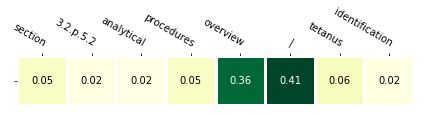

0.9791029095649719

In [28]:
# attention heads = 1
classifier.eval()
classifier('section 3.2.p.5.2 analytical procedures overview | tetanus identification', show_attention = True)

In [ ]:
classifier.eval()
classifier.compute_accuracy(labelled_sentences)

#### Save

In [62]:
#torch.save(classifier.state_dict(), path_to_NLP + '\\saves\\DL4NLP_I2_sentence_classifier.pth')